In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [61]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [62]:
df_merged.shape

(40000, 10)

In [63]:
%run 0-Function-Helper.ipynb

In [64]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42,
    stratify=df_merged["clickbait"]
)

In [65]:
x_test, x_val, y_test, y_val = train_test_split(
    x_test, 
    y_test,
    test_size=0.5,  # 50% of the original x_test size for validation
    random_state=42,
    stratify=y_test
)

## Text cleaning 

#### Text Cleaning is also optional and some kind of hyperparameter

In [66]:
# def clean_text(text):
#     text = text.lower()
#     text = re.sub('\[.*?\]','',text)
#     text = re.sub("\\W"," ",text)
#     text = re.sub('https?://\S+|www\.\S+','',text)
#     text = re.sub('<.*?>+',b'',text)
#     text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
#     text = re.sub('\w*\d\w*','',text)
#     return text

## Fitting TFIDF

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_val = vectorization.transform(x_val)

## Trivial model without any library

In [68]:
mask = y_train.astype(bool).values

In [69]:
mask[:100]

array([False,  True, False, False,  True, False,  True,  True, False,
       False,  True, False,  True, False,  True, False,  True,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False,  True,  True, False, False, False,  True, False,
       False, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False, False,  True,
        True])

In [70]:
fake_news_centroid = np.array(xv_train[mask].mean(axis=0)).ravel()
no_fake_news_centroid = np.array(xv_train[~mask].mean(axis=0)).ravel()

In [71]:
xv_train.shape

(32000, 24721)

In [72]:
fake_news_centroid.shape

(24721,)

In [73]:
no_fake_news_centroid.shape

(24721,)

In [74]:
fake_news_score = xv_val.dot(fake_news_centroid-no_fake_news_centroid)
fake_news_score.round(2)

array([-0.  , -0.  , -0.  , ...,  0.01,  0.01,  0.01])

In [75]:
from sklearn.preprocessing import MinMaxScaler

x_val_df = pd.DataFrame(x_val)
print(x_val_df.shape)
x_val_df['clickbait'] = y_val
x_val_df['clickbait_score_model'] = MinMaxScaler().fit_transform(fake_news_score.reshape(-1,1))
x_val_df['clickbait_prediction'] = (x_val_df.clickbait_score_model > 0.3).astype(int)

(4000, 1)


In [76]:
x_val_df

,title,clickbait,clickbait_score_model,clickbait_prediction
16984,‘Rogue One: A Star Wars Story’ Rakes In $155 M...,0,0.130428,0
17575,'Wells Fargo has been out of order for years!'...,0,0.177288,0
33409,Reports: Democrat Anthony Weiner Facing Child-...,1,0.160021,0
34351,"Thank Goodness, Demi Lovato And Selena Gomez A...",1,0.279816,0
7052,Donald Trump kicked One Direction out of his h...,0,0.129075,0
...,...,...,...,...
23477,17 Hot Breakfasts For When You Need To Warm Up,1,0.470042,1
31227,Where the most attractive people in the US com...,1,0.362749,1
21368,Here's How Orphan Black Fans Are Dealing With ...,1,0.320642,1
35611,3 reasons why half of American workers are not...,1,0.330235,1


In [77]:
predictions = x_val_df.clickbait_prediction

{'Accuracy': 0.74475, 'Precision': 0.8785769528228925, 'Recall': 0.568, 'F1 Score': 0.6899483753416338, 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.68      0.92      0.78      2000
           1       0.88      0.57      0.69      2000

    accuracy                           0.74      4000
   macro avg       0.78      0.74      0.74      4000
weighted avg       0.78      0.74      0.74      4000



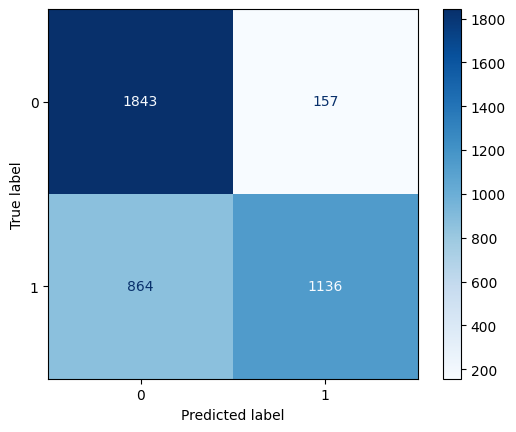

In [78]:
create_summary_for_model_metrics(y_val, predictions, None)

In [20]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.70      0.92      0.79      4014
           1       0.88      0.60      0.71      3986

    accuracy                           0.76      8000
   macro avg       0.79      0.76      0.75      8000
weighted avg       0.79      0.76      0.75      8000

